In [49]:
from plugins.calibration.sn_calibration_baseline.camera import Camera
import cv2
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json

In [50]:
camParamsPath = "Labels-GameState - Copy.json"
imgPath = 'Images/img1/'
maskPath = 'out2/tta/'
logo = cv2.imread('University_of_Liège_logo.png')
logo = cv2.copyMakeBorder(logo, 0, 0, logo.shape[1]//4, logo.shape[1]//4, cv2.BORDER_CONSTANT, value=(255, 255, 255))

In [51]:
with open(camParamsPath, "r") as f:
	camParams = json.load(f)["annotations"]
camParams = [x["parameters"] for x in camParams if x["supercategory"] == "camera"]
cam = Camera()

In [52]:
billboardDepth = 4
billboardHeight = 2
worldSrcPoints = np.float64([[-105/2 - billboardDepth, 34, 0], [-105/2 - billboardDepth, 34, -billboardHeight], [-105/2 - billboardDepth, -34, -billboardHeight], [-105/2 - billboardDepth, -34, 0]])
poly = PolynomialFeatures(degree=2, include_bias=True)

In [61]:
def superimposeNewContent(it):  # it is 0-indexed !
	itCamParams = camParams[it]
	tmpIt = it
	while type(itCamParams) == type(None):
		# print("camParams is None, iteration = ", iteration)
		tmpIt -= 1
		itCamParams = camParams[tmpIt]
	# Make a if condition depending on if camParams is a list or a dictionary
	if type(itCamParams) == list:
		# If it is a list then it is an homography
		cam.from_homography(itCamParams)
	elif type(itCamParams) == dict:
		cam.from_json_parameters(itCamParams)
	else:
		print("Error: itCamParams is neither a list nor a dictionary, it = ", it)
		return

	imgIndex = str(it + 1).zfill(6)
	img = cv2.imread(imgPath + imgIndex + '.jpg')
	mask = cv2.imread(maskPath + imgIndex + '.png', cv2.IMREAD_GRAYSCALE)
	srcPoints = np.float32([cam.project_point(pt, distort=False)[:2] for pt in worldSrcPoints])
	srcPoints[1][0] = srcPoints[0][0]
	srcPoints[2][0] = srcPoints[3][0]
	warpedImgHeight = np.ceil(max(abs(srcPoints[0][1] - srcPoints[1][1]), abs(srcPoints[2][1] - srcPoints[3][1])) * 5).astype(np.int32)
	if warpedImgHeight % 2 == 0:
		warpedImgHeight += 1
	warpedImgSize = (int(round(warpedImgHeight * 68 / billboardHeight)), warpedImgHeight)
	dstPoints = np.float32([[0, warpedImgSize[1]], [0, 0], [warpedImgSize[0], 0], [warpedImgSize[0], warpedImgSize[1]]])
	M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
	warpedMask = cv2.warpPerspective(mask, M, warpedImgSize)
	y, x = np.where(warpedMask > 0)
	X = poly.fit_transform(x.reshape(-1, 1))
	reg = LinearRegression().fit(X, y)
	Y = reg.predict(X)
	width = np.mean(abs(y - Y)) * 2
	gridWidth = warpedImgSize[0]
	gridHeight = warpedImgSize[1]

	# squareSize = gridHeight // 3
	# grid = np.zeros((gridHeight, gridWidth, 3), dtype=np.uint8)
	# grid.fill(255)
	# for i in range(0, gridWidth, squareSize):
	# 	cv2.line(grid, (i, 0), (i, gridHeight), (0, 0, 0), 3)
	# for i in range(0, gridHeight, squareSize):
	# 	cv2.line(grid, (0, i), (gridWidth, i), (0, 0, 0), 3)

	logoHeight = warpedImgSize[1]
	logoWidth = int(round(logo.shape[1] * logoHeight / logo.shape[0]))
	logoResized = cv2.resize(logo, (logoWidth, logoHeight), interpolation=cv2.INTER_AREA)
	logos = np.concatenate([logoResized for _ in range(gridWidth//logoWidth)], axis=1)
	logos = np.concatenate([logos, np.zeros((logoHeight, gridWidth - logos.shape[1], 3), dtype=np.uint8)], axis=1)
	grid = logos

	x = np.arange(0, gridWidth)
	x = poly.fit_transform(x.reshape(-1, 1))
	y = [(x_ - width, x_ + width) for x_ in reg.predict(x)]
	y = np.rint(np.array(y)).astype(np.int32)
	mapX = - np.ones(warpedMask.shape, dtype=np.float32)
	mapY = - np.ones(warpedMask.shape, dtype=np.float32)
	for i in range(gridHeight):
		for j in range(gridWidth):
			mapX[i, j] = j
	for j , (yBegin, yEnd) in enumerate(y):
		length = yEnd - yBegin
		for i in range(yBegin, yEnd + 1):
			mapY[i, j] = (i - yBegin) / length * (gridHeight - 1)
	remappedGrid = cv2.remap(grid, mapX, mapY, cv2.INTER_LINEAR)
	warpedToWorldGrid = cv2.warpPerspective(remappedGrid, M, img.shape[1::-1], flags=cv2.WARP_INVERSE_MAP)
	binMask = mask > 0
	finalImg = deepcopy(img)
	finalImg[binMask] = warpedToWorldGrid[binMask]
	return finalImg


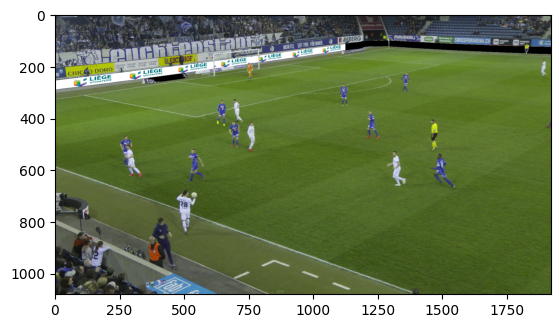

In [60]:
plt.imshow(cv2.cvtColor(superimposeNewContent(500), cv2.COLOR_BGR2RGB))

In [62]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  #type: ignore
out = cv2.VideoWriter('cam_calib_video.mp4', fourcc, 25, (1920, 1080))

for i in tqdm(range(500, 750)):
    out.write(superimposeNewContent(i))

out.release()

  1%|          | 3/250 [00:18<24:37,  5.98s/it]